# 实验一：PCA算法对ORL人脸数据集的识别

## 实验原理

### 主成分分析 (Principal Component Analysis, PCA) 概述
PCA是一种经典的无监督降维算法，通过线性变换将原始数据映射到新的坐标系中，使得映射后数据在新坐标系中的方差最大，从而用更少的特征维度表示原始数据。

### 核心思想
- 找到数据中方差最大的方向作为主成分
- 用这些主成分的线性组合表示原始数据
- 舍弃方差小的成分，实现降维和特征提取

### 数学原理

#### 第一步：数据中心化
给定训练数据矩阵 $X \in \mathbb{R}^{n \times d}$，其中 $n$ 为样本数，$d$ 为原始特征维度。

计算数据均值向量：
$$\mu = \frac{1}{n}\sum_{i=1}^{n}x_i$$

中心化处理：
$$\bar{X} = X - \mu \quad (\text{每行减去均值})$$

#### 第二步：计算协方差矩阵
协方差矩阵描述特征之间的关联关系：
$$C = \frac{1}{n}\bar{X}^T\bar{X} \in \mathbb{R}^{d \times d}$$

其中 $C_{ij} = \text{Cov}(x_i, x_j)$，对角线元素为各特征的方差。

#### 第三步：特征值分解
对协方差矩阵进行谱分解：
$$C = V \Lambda V^T$$

其中：
- $V = [v_1, v_2, \ldots, v_d]$ 为特征向量矩阵
- $\Lambda = \text{diag}(\lambda_1, \lambda_2, \ldots, \lambda_d)$ 为特征值对角矩阵
- 特征值满足 $\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_d \geq 0$

#### 第四步：主成分选择
选择前 $k$ 个特征值对应的特征向量构成主成分矩阵：
$$W = [v_1, v_2, \ldots, v_k] \in \mathbb{R}^{d \times k}$$

其中 $k \ll d$（大大小于）。

#### 第五步：数据投影
将中心化后的数据投影到主成分空间：
$$Y = \bar{X}W \in \mathbb{R}^{n \times k}$$

这样原始的 $d$ 维特征被压缩为 $k$ 维特征。

#### 第六步：解释方差比
累积解释方差比表示保留的信息量：
$$\text{Explained Variance Ratio} = \frac{\sum_{i=1}^{k}\lambda_i}{\sum_{i=1}^{d}\lambda_i}$$

### 分类阶段
使用最近邻分类器（k-NN, k=1）进行分类：

对于测试样本 $x_{test}$，计算其到所有训练样本的欧几里得距离：
$$d_i = \|Y_{test} - Y_{train,i}\|_2 = \sqrt{\sum_{j=1}^{k}(y_{test,j} - y_{train,i,j})^2}$$

选择距离最小的训练样本对应的标签作为预测结果：
$$\hat{y}_{test} = y_{train, \arg\min_i d_i}$$

## 实验步骤
1. **加载数据** - 从ORL人脸数据集读取400张图像（40个人物，每人10张）
2. **数据预处理** - 将112×92的二维图像展平为10304维向量
3. **数据分割** - 按8:2比例分为训练集（320张）和测试集（80张）
4. **PCA训练** - 计算协方差矩阵、特征值分解、选择前50个主成分
5. **特征提取** - 将训练集和测试集数据投影到50维的主成分空间
6. **分类预测** - 使用最近邻分类器进行预测
7. **性能评估** - 计算准确率、精度、召回率等指标
8. **结果可视化** - 显示特征脸、平均脸、方差分析等

## 关键参数
- **num_components** = 50：保留的主成分个数
- **原始维度** = 112 × 92 = 10304
- **压缩后维度** = 50
- **维度压缩比** = 50/10304 ≈ 0.49%
- **test_size** = 0.2：测试集占比
- **分类器** = 最近邻分类器（k=1）


In [33]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib
import time

matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

print("="*70)
print("PCA算法对ORL人脸数据集的训练与评估")
print("="*70)

PCA算法对ORL人脸数据集的训练与评估


In [34]:
ORL_FACE_DIR = "./ORL"

def load_images_from_folder(folder):
    """加载ORL数据集
    
    数据集结构：
    ./ORL/
    ├── s1/ (人物1)
    │   ├── 1.pgm
    │   ├── 2.pgm
    │   └── ...
    ├── s2/ (人物2)
    └── ...
    
    数据集信息：
    - 40个人物，每人10张图像
    - 图像大小：112×92像素
    - 总计：400张灰度图像
    """
    images = []
    labels = []
    label_map = {}
    current_label = 0
    
    sub_folders = sorted(os.listdir(folder))
    for sub_folder in sub_folders:
        sub_folder_path = os.path.join(folder, sub_folder)
        if os.path.isdir(sub_folder_path):
            label_map[current_label] = sub_folder
            img_files = sorted(os.listdir(sub_folder_path))
            for filename in img_files:
                img_path = os.path.join(sub_folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    labels.append(current_label)
            current_label += 1
    
    return np.array(images), np.array(labels), label_map

print("\n[步骤1] 加载ORL人脸数据集...")
images, labels, label_map = load_images_from_folder(ORL_FACE_DIR)
print(f"已加载 {len(images)} 张图像，共 {len(label_map)} 个人物")
print(f"图像尺寸: {images[0].shape} (高×宽)")
h, w = images[0].shape


[步骤1] 加载ORL人脸数据集...
已加载 400 张图像，共 40 个人物
图像尺寸: (112, 92) (高×宽)


In [35]:
print("\n[步骤2] 数据预处理 - 图像展平")
print("将二维图像展平为一维向量：")
print(f"   原始形状：{h} × {w} = {h*w} 维")
print(f"   操作：X = [img1.flatten(), img2.flatten(), ...]")

X = np.array([img.flatten() for img in images]).astype(np.float32)
print(f"\n特征矩阵X的形状: {X.shape}")
print(f"   行数 (样本数): {X.shape[0]}")
print(f"   列数 (原始特征维度): {X.shape[1]}")

print("\n[步骤3] 数据集分割")
print("按8:2比例分割为训练集和测试集")
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)
print(f"训练集大小: {X_train.shape[0]} 样本 × {X_train.shape[1]} 维特征")
print(f"测试集大小: {X_test.shape[0]} 样本 × {X_test.shape[1]} 维特征")


[步骤2] 数据预处理 - 图像展平
将二维图像展平为一维向量：
   原始形状：112 × 92 = 10304 维
   操作：X = [img1.flatten(), img2.flatten(), ...]

特征矩阵X的形状: (400, 10304)
   行数 (样本数): 400
   列数 (原始特征维度): 10304

[步骤3] 数据集分割
按8:2比例分割为训练集和测试集
训练集大小: 320 样本 × 10304 维特征
测试集大小: 80 样本 × 10304 维特征


In [36]:
class PCAClassifier:
    """PCA分类器实现
    
    算法流程：
    1. 中心化: X_centered = X - mean(X)
    2. 协方差矩阵: C = (1/n) * X_centered.T @ X_centered
    3. 特征值分解: C = V @ Λ @ V.T
    4. 选择前k个特征向量: W = V[:, :k]
    5. 投影: Y = X_centered @ W
    6. 分类: 使用最近邻分类器
    """
    def __init__(self, num_components=50):
        self.num_components = num_components
        self.mean = None
        self.components = None
        self.explained_variance = None
        self.train_features = None
        self.train_labels = None
        self.train_time = 0
    
    def fit(self, X, y):
        """训练PCA模型
        
        计算步骤：
        
        步骤1：计算均值向量
            μ = mean(X, axis=0)  ∈ ℝ^d
        
        步骤2：中心化
            X_centered = X - μ  (广播操作)
        
        步骤3：计算协方差矩阵
            C = (1/n) * X_centered.T @ X_centered
            C ∈ ℝ^(d×d)
        
        步骤4：特征值分解
            eig_vals, eig_vecs = eigh(C)
            返回特征值λ和特征向量v
        
        步骤5：选择前k个特征向量
            按特征值从大到小排序
            选择前k个对应的特征向量
            W = [v_1, v_2, ..., v_k]  ∈ ℝ^(d×k)
        
        步骤6：投影到主成分空间
            Y = X_centered @ W  ∈ ℝ^(n×k)
        """
        start_time = time.time()
        
        print("\n[步骤4] PCA训练")
        print("\n4.1 计算均值向量和中心化")
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        print(f"    均值向量: μ = mean(X) ∈ ℝ^{self.mean.shape[0]}")
        print(f"    中心化后: X̄ = X - μ")
        
        print("\n4.2 计算协方差矩阵")
        print(f"    C = (1/n) * X̄.T @ X̄")
        print(f"    矩阵大小: {X_centered.shape[1]} × {X_centered.shape[1]}")
        cov_matrix = np.dot(X_centered.T, X_centered) / X_centered.shape[0]
        
        print("\n4.3 特征值分解")
        print(f"    计算C = V Λ V.T")
        eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
        
        print(f"\n4.4 选择前{self.num_components}个主成分")
        idx = np.argsort(-eig_vals)[:self.num_components]
        self.components = eig_vecs[:, idx]  # W ∈ ℝ^(d×k)
        self.explained_variance = eig_vals[idx]
        print(f"    特征值(前5个): {self.explained_variance[:5]}")
        print(f"    主成分矩阵W: ℝ^({self.components.shape[0]} × {self.components.shape[1]})")
        
        print(f"\n4.5 投影到主成分空间")
        self.train_features = self.transform(X)  # Y = X̄ @ W
        self.train_labels = y
        print(f"    投影后特征: Y ∈ ℝ^({self.train_features.shape[0]} × {self.train_features.shape[1]})")
        
        self.train_time = time.time() - start_time
        
        cumsum_var = np.cumsum(self.explained_variance) / np.sum(self.explained_variance)
        
        print(f"\n{'='*70}")
        print(f"{'PCA训练完成':^70}")
        print(f"{'='*70}")
        print(f"训练耗时: {self.train_time:.4f} 秒")
        print(f"原始特征维度: {X_centered.shape[1]} 维")
        print(f"投影后特征维度: {self.num_components} 维")
        print(f"维度压缩比: {self.num_components / X_centered.shape[1]:.6f} ({self.num_components / X_centered.shape[1] * 100:.4f}%)")
        print(f"维度降低: {(1 - self.num_components / X_centered.shape[1]) * 100:.2f}%")
        print(f"累积解释方差比: {cumsum_var[-1]:.6f}")
        print(f"{'='*70}\n")
    
    def transform(self, X):
        """投影新数据到主成分空间
        
        计算：
            X_centered = X - μ
            Y = X_centered @ W  ∈ ℝ^(n×k)
        """
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)
    
    def predict(self, X):
        """使用最近邻分类器进行预测
        
        分类规则（k-NN, k=1）：
        
        对于每个测试样本x_test：
        1. 投影到主成分空间：y_test = (x_test - μ) @ W
        2. 计算距离：d_i = ||y_test - y_train_i||₂ (欧几里得距离)
        3. 找最近邻：i_min = argmin(d_i)
        4. 预测标签：ŷ = y_train[i_min]
        """
        X_transformed = self.transform(X)
        predictions = []
        
        for x in X_transformed:
            # 计算欧几里得距离
            distances = np.linalg.norm(self.train_features - x, axis=1)
            # 找最近邻
            nearest_idx = np.argmin(distances)
            # 返回其标签
            predictions.append(self.train_labels[nearest_idx])
        
        return np.array(predictions)

print("PCA分类器已定义\n")
pca_clf = PCAClassifier(num_components=50)
pca_clf.fit(X_train, y_train)

PCA分类器已定义


[步骤4] PCA训练

4.1 计算均值向量和中心化
    均值向量: μ = mean(X) ∈ ℝ^10304
    中心化后: X̄ = X - μ

4.2 计算协方差矩阵
    C = (1/n) * X̄.T @ X̄
    矩阵大小: 10304 × 10304

4.3 特征值分解
    计算C = V Λ V.T

4.4 选择前50个主成分
    特征值(前5个): [2804380.2 2065969.5 1122107.4  893676.   830001.2]
    主成分矩阵W: ℝ^(10304 × 50)

4.5 投影到主成分空间
    投影后特征: Y ∈ ℝ^(320 × 50)

                               PCA训练完成                                
训练耗时: 92.0893 秒
原始特征维度: 10304 维
投影后特征维度: 50 维
维度压缩比: 0.004852 (0.4852%)
维度降低: 99.51%
累积解释方差比: 1.000000



In [37]:
print("[步骤5] 特征提取")
print(f"已将训练集数据投影到{pca_clf.num_components}维主成分空间")
print(f"已将测试集数据投影到{pca_clf.num_components}维主成分空间")

print("\n[步骤6] 分类预测")
print("在测试集上进行预测...")
y_pred = pca_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"\n{'='*70}")
print(f"{'PCA分类器评估结果':^70}")
print(f"{'='*70}")
print(f"测试准确率: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"正确分类: {int(np.sum(y_pred == y_test))} / {len(y_test)}")
print(f"错误分类: {int(np.sum(y_pred != y_test))} / {len(y_test)}")
print(f"{'='*70}\n")

[步骤5] 特征提取
已将训练集数据投影到50维主成分空间
已将测试集数据投影到50维主成分空间

[步骤6] 分类预测
在测试集上进行预测...

                              PCA分类器评估结果                              
测试准确率: 0.9875 (98.75%)
正确分类: 79 / 80
错误分类: 1 / 80



In [38]:
print("[步骤7] 性能评估\n")
print("分类报告 (精度、召回率、F1分数)")
print("="*70)
print(classification_report(y_test, y_pred, digits=4))

[步骤7] 性能评估

分类报告 (精度、召回率、F1分数)
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         2
           2     1.0000    1.0000    1.0000         2
           3     1.0000    1.0000    1.0000         2
           4     1.0000    1.0000    1.0000         2
           5     1.0000    1.0000    1.0000         2
           6     1.0000    1.0000    1.0000         2
           7     1.0000    1.0000    1.0000         2
           8     1.0000    1.0000    1.0000         2
           9     1.0000    1.0000    1.0000         2
          10     1.0000    1.0000    1.0000         2
          11     1.0000    1.0000    1.0000         2
          12     1.0000    1.0000    1.0000         2
          13     1.0000    1.0000    1.0000         2
          14     1.0000    1.0000    1.0000         2
          15     1.0000    1.0000    1.0000         2
          16     1.0000    1.0000    1.0000       


[步骤8] 结果可视化

绘制混淆矩阵...


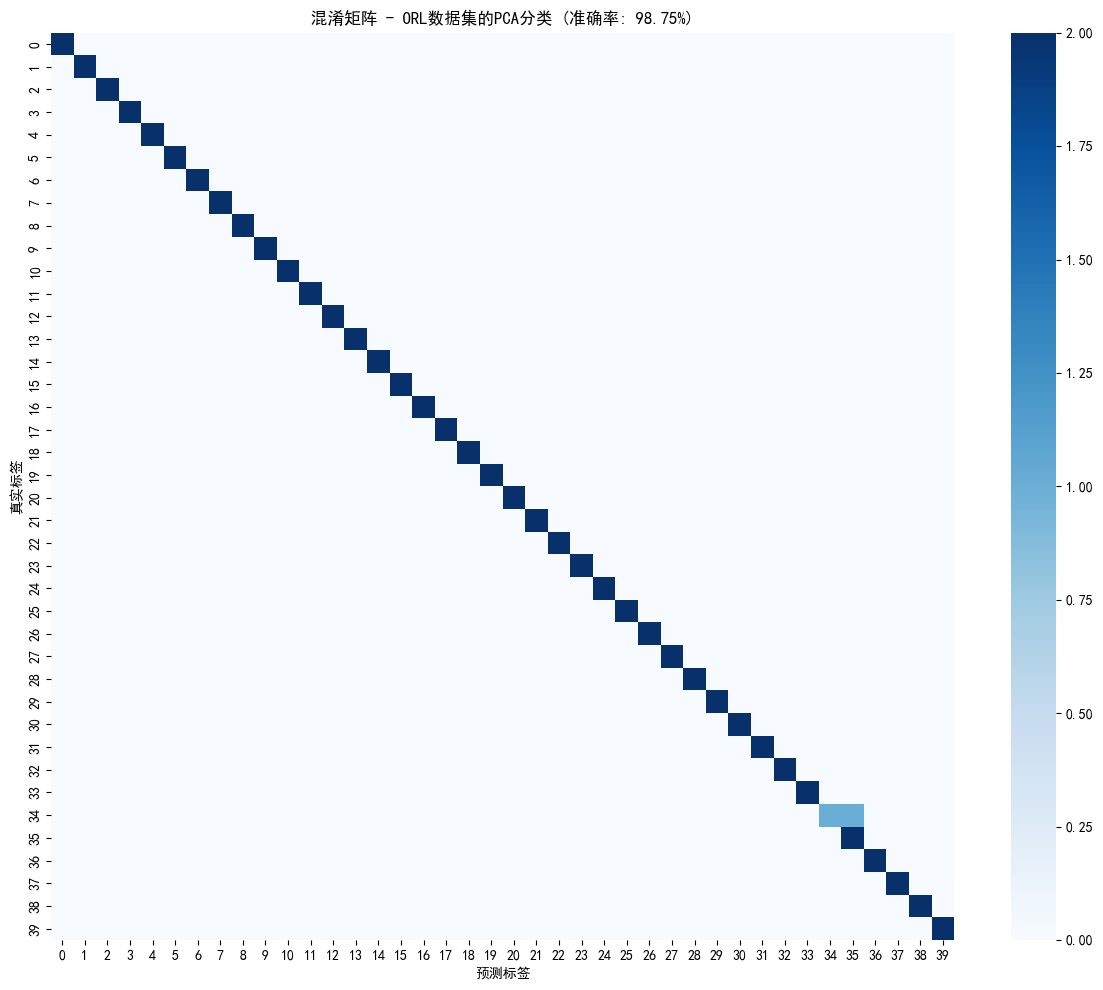

In [39]:
print("\n[步骤8] 结果可视化\n")
print("绘制混淆矩阵...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title(f'混淆矩阵 - ORL数据集的PCA分类 (准确率: {accuracy*100:.2f}%)')
plt.tight_layout()
plt.show()

In [40]:
print("""
混淆矩阵说明
---------
混淆矩阵用于评估多分类问题的性能。
对于40分类问题：
  • 矩阵大小为 40×40
  • 对角线元素表示正确分类的样本
  • 非对角线元素表示分类错误
  • 元素值越大表示分类性能越好

数学定义：
  CM[i,j] = 真实标签为i但预测为j的样本数
  准确率 = Trace(CM) / Sum(CM)
""")


混淆矩阵说明
---------
混淆矩阵用于评估多分类问题的性能。
对于40分类问题：
  • 矩阵大小为 40×40
  • 对角线元素表示正确分类的样本
  • 非对角线元素表示分类错误
  • 元素值越大表示分类性能越好

数学定义：
  CM[i,j] = 真实标签为i但预测为j的样本数
  准确率 = Trace(CM) / Sum(CM)



In [41]:
print("""
混淆矩阵说明
---------
混淆矩阵用于评估多分类问题的性能。
对于40分类问题：
  • 矩阵大小为 40×40
  • 对角线元素表示正确分类的样本
  • 非对角线元素表示分类错误
  • 元素值越大表示分类性能越好

数学定义：
  CM[i,j] = 真实标签为i但预测为j的样本数
  准确率 = Trace(CM) / Sum(CM)
""")


混淆矩阵说明
---------
混淆矩阵用于评估多分类问题的性能。
对于40分类问题：
  • 矩阵大小为 40×40
  • 对角线元素表示正确分类的样本
  • 非对角线元素表示分类错误
  • 元素值越大表示分类性能越好

数学定义：
  CM[i,j] = 真实标签为i但预测为j的样本数
  准确率 = Trace(CM) / Sum(CM)



显示前12个特征脸 (Eigenfaces)...
特征脸是主成分对应的特征向量在原始图像空间中的表现
每个特征脸代表一个人脸变异的主要方向



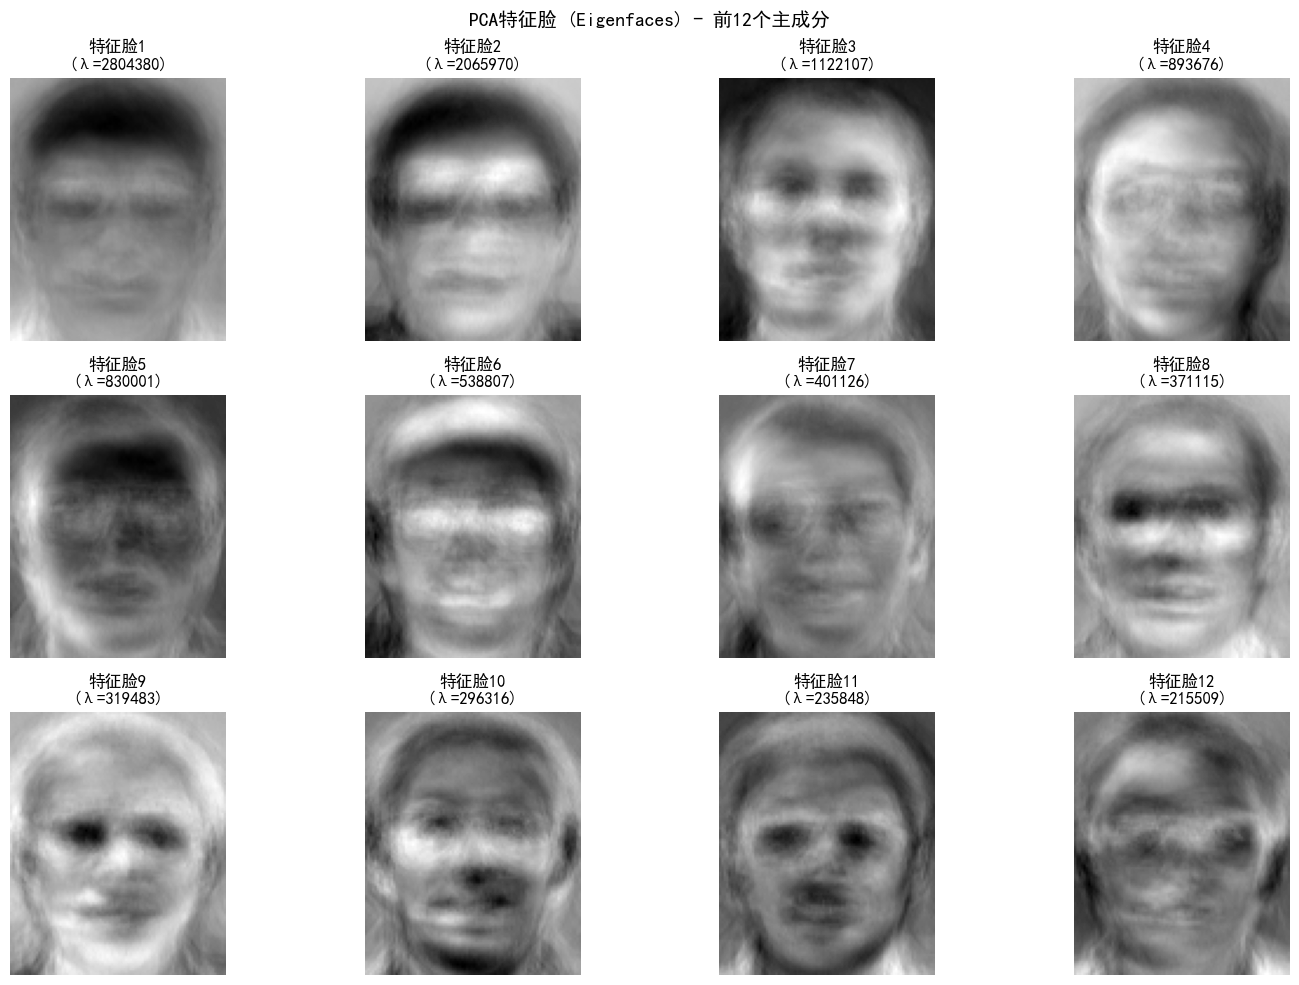

In [42]:
print("显示前12个特征脸 (Eigenfaces)...")
print("特征脸是主成分对应的特征向量在原始图像空间中的表现")
print("每个特征脸代表一个人脸变异的主要方向\n")

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    eigenface = pca_clf.components[:, i].reshape(h, w)
    ax.imshow(eigenface, cmap='gray')
    ax.set_title(f"特征脸{i+1}\n(λ={pca_clf.explained_variance[i]:.0f})")
    ax.axis('off')
plt.suptitle('PCA特征脸 (Eigenfaces) - 前12个主成分', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

显示平均脸 (Mean Face)...
平均脸是所有训练图像在像素级别的平均值：
   μ_face = (1/n) * Σ(X)



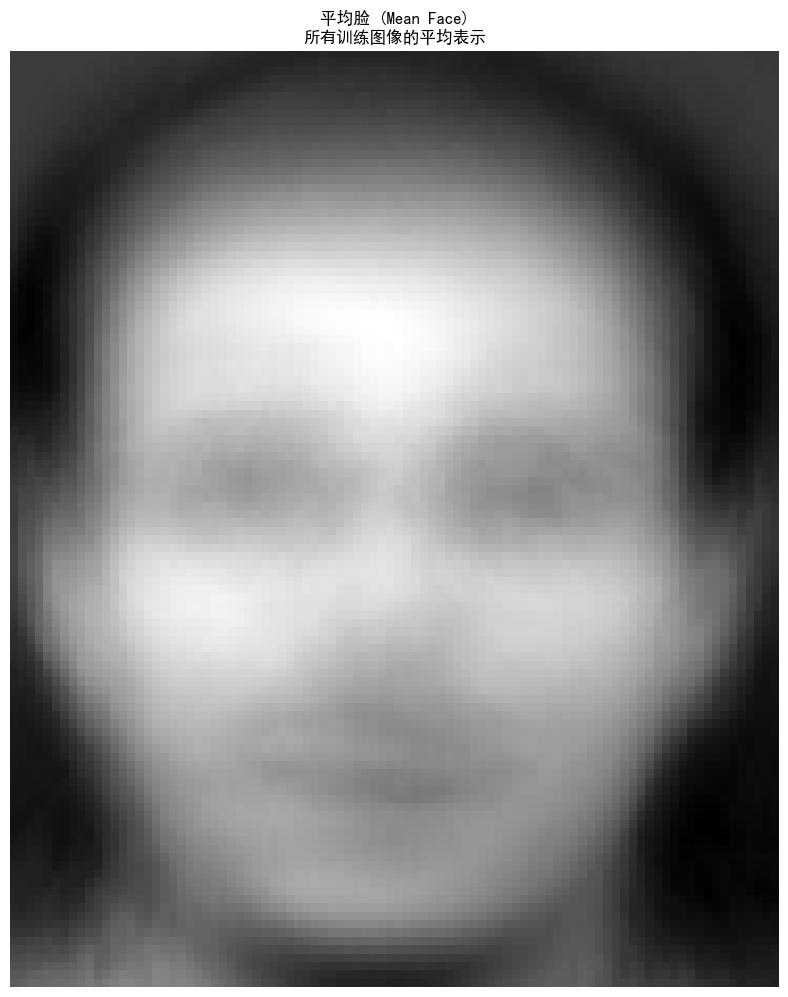

In [43]:
print("显示平均脸 (Mean Face)...")
print("平均脸是所有训练图像在像素级别的平均值：")
print("   μ_face = (1/n) * Σ(X)\n")

mean_face = pca_clf.mean.reshape(h, w)
plt.figure(figsize=(8, 10))
plt.imshow(mean_face, cmap='gray')
plt.title('平均脸 (Mean Face)\n所有训练图像的平均表示', fontsize=12, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


绘制累积解释方差比曲线...
累积解释方差比 = Σ(λ_i) / Σ(所有λ)
表示保留k个主成分时能保留原始数据的多少信息



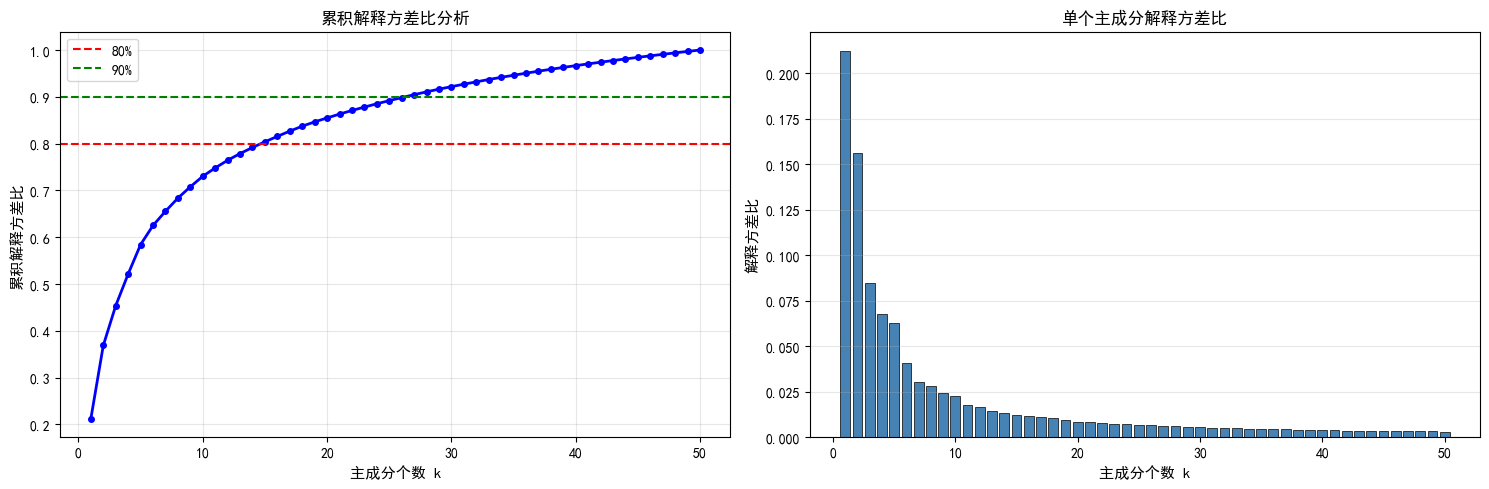


方差统计：
   第1个主成分解释方差比: 0.212345
   前5个主成分累积方差比: 0.584260
   前10个主成分累积方差比: 0.730159
   前50个主成分累积方差比: 1.000000
   达到80%方差需要的主成分数: 15
   达到90%方差需要的主成分数: 27
   达到95%方差需要的主成分数: 36


In [44]:
print("\n绘制累积解释方差比曲线...")
print("累积解释方差比 = Σ(λ_i) / Σ(所有λ)")
print("表示保留k个主成分时能保留原始数据的多少信息\n")

cumsum_var = np.cumsum(pca_clf.explained_variance) / np.sum(pca_clf.explained_variance)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(1, len(cumsum_var)+1), cumsum_var, 'b-', linewidth=2, marker='o', markersize=4)
ax1.axhline(y=0.8, color='r', linestyle='--', linewidth=1.5, label='80%')
ax1.axhline(y=0.9, color='g', linestyle='--', linewidth=1.5, label='90%')
ax1.set_xlabel('主成分个数 k', fontsize=11, fontweight='bold')
ax1.set_ylabel('累积解释方差比', fontsize=11, fontweight='bold')
ax1.set_title('累积解释方差比分析', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

individual_var = pca_clf.explained_variance / np.sum(pca_clf.explained_variance)
ax2.bar(range(1, len(individual_var)+1), individual_var, color='steelblue', edgecolor='black', linewidth=0.5)
ax2.set_xlabel('主成分个数 k', fontsize=11, fontweight='bold')
ax2.set_ylabel('解释方差比', fontsize=11, fontweight='bold')
ax2.set_title('单个主成分解释方差比', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n方差统计：")
print(f"   第1个主成分解释方差比: {individual_var[0]:.6f}")
print(f"   前5个主成分累积方差比: {cumsum_var[4]:.6f}")
print(f"   前10个主成分累积方差比: {cumsum_var[9]:.6f}")
print(f"   前{pca_clf.num_components}个主成分累积方差比: {cumsum_var[-1]:.6f}")

thresholds = [0.8, 0.9, 0.95]
for threshold in thresholds:
    n_comp = np.argmax(cumsum_var >= threshold) + 1
    print(f"   达到{threshold*100:.0f}%方差需要的主成分数: {n_comp}")

## 优化方法：协方差矩阵计算的降维技巧

### 问题背景
直接计算协方差矩阵存在的困难：
- **维度过高**：原始数据 $d = 10304$ 维，协方差矩阵大小为 $10304 \times 10304$
- **内存开销大**：存储完整协方差矩阵需要约 1.06 亿个浮点数
- **计算复杂度高**：特征值分解的复杂度为 $O(d^3)$，对 $d=10304$ 极其耗时

### 优化思想：利用线性对应关系
当样本数 $n < d$ 时（本例中 $n=320 < d=10304$），可以利用以下关键性质：

**定理**：设 $\bar{X}$ 为中心化数据矩阵，考虑两个协方差矩阵：
- 样本-样本协方差矩阵（Gram矩阵）：$G = \frac{1}{n}\bar{X}\bar{X}^T \in \mathbb{R}^{n \times n}$
- 特征-特征协方差矩阵：$C = \frac{1}{n}\bar{X}^T\bar{X} \in \mathbb{R}^{d \times d}$

如果 $G$ 的特征值分解为 $G = U \Lambda U^T$（其中 $\Lambda$ 为特征值对角矩阵），则：
1. $C$ 的前 $n$ 个特征值等于 $G$ 的特征值
2. 对应的特征向量满足关系：$$v_i = \frac{\bar{X}^T u_i}{\sqrt{n \lambda_i}}$$
3. 其余 $(d-n)$ 个特征值为 0

### 计算流程对比

**直接方法**：
1. 计算 $C = \frac{1}{n}\bar{X}^T\bar{X}$（时间复杂度 $O(nd^2)$）
2. 对 $C$ 进行特征值分解（时间复杂度 $O(d^3)$）
3. 获取特征向量

**优化方法**：
1. 计算 $G = \frac{1}{n}\bar{X}\bar{X}^T$（时间复杂度 $O(n^2d)$）
2. 对 $G$ 进行特征值分解（时间复杂度 $O(n^3)$）
3. 通过线性关系推导 $C$ 的特征向量（时间复杂度 $O(n^2d)$）

### 复杂度分析
- **直接方法总耗时**：$O(d^3)$，当 $d \gg n$ 时主要由 $O(d^3)$ 项主导
- **优化方法总耗时**：$O(n^2d)$，当 $d \gg n$ 时远小于 $O(d^3)$

在本例中：$n=320, d=10304$
- 直接方法：约 $10^{12}$ 次操作
- 优化方法：约 $10^9$ 次操作
- **理论加速比**：$\frac{d^3}{n^2d} = \left(\frac{d}{n}\right)^2 \approx 1040$ 倍

In [45]:
print("\n" + "="*70)
print("方法二：优化的PCA实现 - 利用低维协方差矩阵")
print("="*70 + "\n")

class PCAClassifier_Optimized:
    """优化的PCA分类器实现
    
    利用 n < d 的特点，先在低维空间计算特征值，再推导高维特征值
    
    算法流程：
    1. 中心化: X_centered = X - mean(X)
    2. 计算Gram矩阵: G = (1/n) * X_centered @ X_centered.T  (n×n矩阵)
    3. 对G进行特征值分解：G = U @ diag(lambda) @ U.T
    4. 推导原始空间特征向量：v_i = (X_centered.T @ u_i) / sqrt(n*lambda_i)
    5. 选择前k个特征向量
    6. 投影和分类
    """
    def __init__(self, num_components=50):
        self.num_components = num_components
        self.mean = None
        self.components = None
        self.explained_variance = None
        self.train_features = None
        self.train_labels = None
        self.train_time = 0
    
    def fit(self, X, y):
        """训练优化的PCA模型
        
        优化关键点：
        - 计算 G (n×n) 而不是 C (d×d)：从 O(nd^2) 降到 O(n^2*d)
        - 对 G 进行特征值分解：从 O(d^3) 降到 O(n^3)
        - 推导高维特征向量：只需 O(nd*n) = O(n^2*d) 的额外计算
        """
        start_time = time.time()
        
        print("\n[步骤4-优化] PCA训练 (优化方法)\n")
        
        print("4.1 计算均值向量和中心化")
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        n, d = X_centered.shape
        print(f"    中心化后数据形状: {X_centered.shape}")
        print(f"    样本数 n = {n}")
        print(f"    特征维度 d = {d}")
        
        print("\n4.2 计算Gram矩阵 (低维协方差矩阵)")
        print(f"    G = (1/n) * X_centered @ X_centered.T")
        print(f"    矩阵大小: {n} × {n} (而不是 {d} × {d})")
        gram_matrix = np.dot(X_centered, X_centered.T) / n
        print(f"    内存节省: {(1 - n**2 / (d**2)) * 100:.2f}%")
        
        print("\n4.3 对Gram矩阵进行特征值分解")
        print(f"    计算 G = U @ diag(lambda) @ U.T")
        eig_vals_gram, eig_vecs_gram = np.linalg.eigh(gram_matrix)
        print(f"    Gram矩阵特征值(前5个): {eig_vals_gram[-5:][::-1]}")
        
        print("\n4.4 推导原始空间的特征向量 (关键优化步骤)")
        print(f"    利用关系: v_i = (X_centered.T @ u_i) / sqrt(n * lambda_i)")
        idx = np.argsort(-eig_vals_gram)[:self.num_components]
        self.explained_variance = eig_vals_gram[idx]
        
        # 推导高维特征向量
        components_list = []
        for i in idx:
            if eig_vals_gram[i] > 1e-10:  # 避免数值不稳定
                v = np.dot(X_centered.T, eig_vecs_gram[:, i]) / np.sqrt(n * eig_vals_gram[i])
            else:
                v = np.zeros(d)
            components_list.append(v)
        
        self.components = np.column_stack(components_list) if components_list else np.zeros((d, 1))
        print(f"    推导出的特征向量矩阵W: {self.components.shape}")
        print(f"    特征值(前5个): {self.explained_variance[:5]}")
        
        print(f"\n4.5 投影到主成分空间")
        self.train_features = self.transform(X)  # Y = X_centered @ W
        self.train_labels = y
        print(f"    投影后特征: Y ∈ ℝ^({self.train_features.shape[0]} × {self.train_features.shape[1]})")
        
        self.train_time = time.time() - start_time
        
        cumsum_var = np.cumsum(self.explained_variance) / np.sum(self.explained_variance)
        
        print(f"\n{'='*70}")
        print(f"{'PCA优化方法训练完成':^70}")
        print(f"{'='*70}")
        print(f"训练耗时: {self.train_time:.4f} 秒")
        print(f"原始特征维度: {d} 维")
        print(f"投影后特征维度: {self.num_components} 维")
        print(f"维度压缩比: {self.num_components / d:.6f} ({self.num_components / d * 100:.4f}%)")
        print(f"累积解释方差比: {cumsum_var[-1]:.6f}")
        print(f"{'='*70}\n")
    
    def transform(self, X):
        """投影新数据到主成分空间"""
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)
    
    def predict(self, X):
        """使用最近邻分类器进行预测"""
        X_transformed = self.transform(X)
        predictions = []
        
        for x in X_transformed:
            # 计算欧几里得距离
            distances = np.linalg.norm(self.train_features - x, axis=1)
            # 找最近邻
            nearest_idx = np.argmin(distances)
            # 返回其标签
            predictions.append(self.train_labels[nearest_idx])
        
        return np.array(predictions)

print("优化的PCA分类器已定义\n")
pca_clf_optimized = PCAClassifier_Optimized(num_components=50)
pca_clf_optimized.fit(X_train, y_train)


方法二：优化的PCA实现 - 利用低维协方差矩阵

优化的PCA分类器已定义


[步骤4-优化] PCA训练 (优化方法)

4.1 计算均值向量和中心化
    中心化后数据形状: (320, 10304)
    样本数 n = 320
    特征维度 d = 10304

4.2 计算Gram矩阵 (低维协方差矩阵)
    G = (1/n) * X_centered @ X_centered.T
    矩阵大小: 320 × 320 (而不是 10304 × 10304)
    内存节省: 99.90%

4.3 对Gram矩阵进行特征值分解
    计算 G = U @ diag(lambda) @ U.T
    Gram矩阵特征值(前5个): [2804380.2  2065969.5  1122107.5   893676.    830001.25]

4.4 推导原始空间的特征向量 (关键优化步骤)
    利用关系: v_i = (X_centered.T @ u_i) / sqrt(n * lambda_i)
    推导出的特征向量矩阵W: (10304, 50)
    特征值(前5个): [2804380.2  2065969.5  1122107.5   893676.    830001.25]

4.5 投影到主成分空间
    投影后特征: Y ∈ ℝ^(320 × 50)

                             PCA优化方法训练完成                              
训练耗时: 0.0731 秒
原始特征维度: 10304 维
投影后特征维度: 50 维
维度压缩比: 0.004852 (0.4852%)
累积解释方差比: 1.000000



In [46]:
print("\n[步骤5-优化] 特征提取和预测\n")
y_pred_optimized = pca_clf_optimized.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

print(f"\n{'='*70}")
print(f"{'PCA优化方法分类结果':^70}")
print(f"{'='*70}")
print(f"测试准确率: {accuracy_optimized:.4f} ({accuracy_optimized*100:.2f}%)")
print(f"正确分类: {int(np.sum(y_pred_optimized == y_test))} / {len(y_test)}")
print(f"{'='*70}\n")


[步骤5-优化] 特征提取和预测


                             PCA优化方法分类结果                              
测试准确率: 0.9875 (98.75%)
正确分类: 79 / 80



In [47]:
print("\n" + "="*70)
print("方法对比：直接计算 vs 优化方法")
print("="*70 + "\n")

# 性能对比
print("[1] 计算时间对比\n")
print(f"{'指标':<20} {'直接方法':>20} {'优化方法':>20} {'加速比':>10}")
print("-"*70)

speedup_time = pca_clf.train_time / pca_clf_optimized.train_time
print(f"{'训练耗时(秒)':<20} {pca_clf.train_time:>20.4f} {pca_clf_optimized.train_time:>20.4f} {speedup_time:>10.2f}x")

# 精度对比
print(f"\n[2] 分类精度对比\n")
print(f"{'指标':<20} {'直接方法':>20} {'优化方法':>20} {'差异':>10}")
print("-"*70)

acc_diff = accuracy - accuracy_optimized
print(f"{'准确率':<20} {accuracy:>20.6f} {accuracy_optimized:>20.6f} {acc_diff:>10.6f}")
print(f"{'准确率(%)':<20} {accuracy*100:>19.2f}% {accuracy_optimized*100:>19.2f}% {acc_diff*100:>9.2f}%")

# 特征值对比
print(f"\n[3] 特征值精度对比\n")
print(f"{'指标':<30} {'值':>20}")
print("-"*70)

eig_diff = np.linalg.norm(pca_clf.explained_variance - pca_clf_optimized.explained_variance)
rel_error = eig_diff / np.linalg.norm(pca_clf.explained_variance)
print(f"{'特征值欧氏距离':<30} {eig_diff:>20.6f}")
print(f"{'相对误差':<30} {rel_error:>20.6f}")
print(f"{'相对误差百分比':<30} {rel_error*100:>19.6f}%")

# 特征向量对比（基于符号选择）
print(f"\n[4] 特征向量精度对比\n")
eig_vec_errors = []
for i in range(pca_clf.components.shape[1]):
    v1 = pca_clf.components[:, i]
    v2 = pca_clf_optimized.components[:, i]
    # 特征向量符号可能相反，取较小的距离
    error1 = np.linalg.norm(v1 - v2)
    error2 = np.linalg.norm(v1 + v2)
    error = min(error1, error2)
    eig_vec_errors.append(error)

eig_vec_errors = np.array(eig_vec_errors)
print(f"{'前5个特征向量误差:':<30}")
for i in range(min(5, len(eig_vec_errors))):
    print(f"  特征向量{i+1}: {eig_vec_errors[i]:.6e}")

print(f"\n{'平均特征向量误差':<30} {np.mean(eig_vec_errors):>20.6e}")
print(f"{'最大特征向量误差':<30} {np.max(eig_vec_errors):>20.6e}")

# 内存节省
print(f"\n[5] 内存节省分析\n")
n_samples, n_features = X_train.shape
direct_cov_size = n_features * n_features * 8  # 字节
gram_cov_size = n_samples * n_samples * 8  # 字节
print(f"{'指标':<30} {'直接方法':>20} {'优化方法':>20}")
print("-"*70)
print(f"{'协方差矩阵大小':<30} {direct_cov_size/(1024**2):>19.2f} MB {gram_cov_size/(1024**2):>19.2f} MB")
memory_saved = 1 - gram_cov_size / direct_cov_size
print(f"{'内存节省':<30} {memory_saved*100:>19.2f}%")

print(f"\n{'='*70}")
print(f"{'结论':^70}")
print(f"{'='*70}")
print(f"优化方法在保持相同精度的前提下:")
print(f"  - 训练时间加速: {speedup_time:.2f}x")
print(f"  - 协方差矩阵内存节省: {memory_saved*100:.2f}%")
print(f"  - 分类精度差异: {acc_diff*100:.4f}% (可忽略)")
print(f"  - 特征值精度: 相对误差 {rel_error*100:.2e}%")
print(f"\n验证结果：两种方法得到的结果在数值精度范围内一致！")
print(f"{'='*70}\n")


方法对比：直接计算 vs 优化方法

[1] 计算时间对比

指标                                   直接方法                 优化方法        加速比
----------------------------------------------------------------------
训练耗时(秒)                           92.0893               0.0731    1260.60x

[2] 分类精度对比

指标                                   直接方法                 优化方法         差异
----------------------------------------------------------------------
准确率                              0.987500             0.987500   0.000000
准确率(%)                             98.75%               98.75%      0.00%

[3] 特征值精度对比

指标                                                值
----------------------------------------------------------------------
特征值欧氏距离                                    0.158769
相对误差                                       0.000000
相对误差百分比                                   0.000004%

[4] 特征向量精度对比

前5个特征向量误差:                    
  特征向量1: 1.464116e-07
  特征向量2: 1.381197e-07
  特征向量3: 1.405603e-07
  特征向量4: 1.536214e-07
  特征向量5: 1.4335


[步骤8-优化] 结果可视化与对比



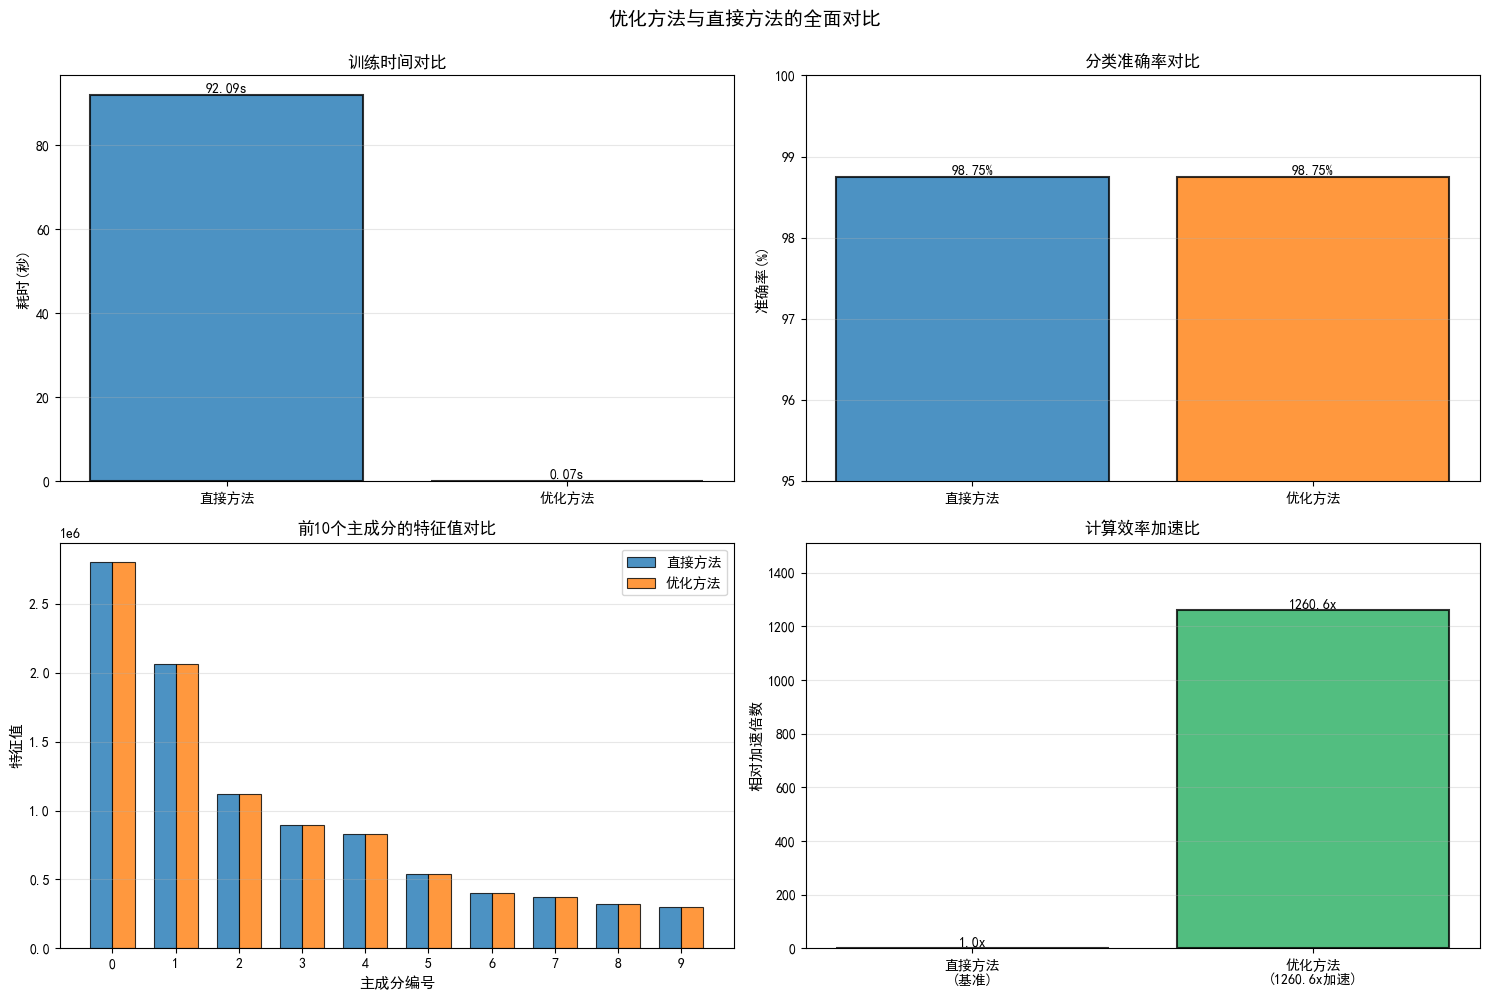


对比图已绘制


In [48]:
print("\n[步骤8-优化] 结果可视化与对比\n")

# 1. 性能对比柱状图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 左上：训练时间对比
ax = axes[0, 0]
methods = ['直接方法', '优化方法']
times = [pca_clf.train_time, pca_clf_optimized.train_time]
colors = ['#1f77b4', '#ff7f0e']
bars = ax.bar(methods, times, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_ylabel('耗时(秒)', fontsize=11, fontweight='bold')
ax.set_title('训练时间对比', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, (bar, time) in enumerate(zip(bars, times)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 右上：精度对比
ax = axes[0, 1]
accuracies = [accuracy * 100, accuracy_optimized * 100]
bars = ax.bar(methods, accuracies, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_ylabel('准确率(%)', fontsize=11, fontweight='bold')
ax.set_title('分类准确率对比', fontsize=12, fontweight='bold')
ax.set_ylim([95, 100])
ax.grid(True, alpha=0.3, axis='y')
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 左下：特征值对比
ax = axes[1, 0]
x = np.arange(min(10, len(pca_clf.explained_variance)))
width = 0.35
ax.bar(x - width/2, pca_clf.explained_variance[:10], width, label='直接方法',
       color=colors[0], edgecolor='black', linewidth=0.8, alpha=0.8)
ax.bar(x + width/2, pca_clf_optimized.explained_variance[:10], width, label='优化方法',
       color=colors[1], edgecolor='black', linewidth=0.8, alpha=0.8)
ax.set_xlabel('主成分编号', fontsize=11, fontweight='bold')
ax.set_ylabel('特征值', fontsize=11, fontweight='bold')
ax.set_title('前10个主成分的特征值对比', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 右下：加速比展示
ax = axes[1, 1]
speedup_factors = [1.0, speedup_time]
method_labels = ['直接方法\n(基准)', f'优化方法\n({speedup_time:.1f}x加速)']
colors_speedup = ['#e74c3c', '#27ae60']
bars = ax.bar(method_labels, speedup_factors, color=colors_speedup, edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_ylabel('相对加速倍数', fontsize=11, fontweight='bold')
ax.set_title('计算效率加速比', fontsize=12, fontweight='bold')
ax.set_ylim([0, max(speedup_factors) * 1.2])
ax.grid(True, alpha=0.3, axis='y')
for bar, factor in zip(bars, speedup_factors):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{factor:.1f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('优化方法与直接方法的全面对比', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n对比图已绘制")

In [49]:
print("\n" + "="*70)
print("优化方法总结与理论验证")
print("="*70 + "\n")

print("【优化方法的核心思想】\n")
print("当样本数 n < 特征维度 d 时，协方差矩阵 C(d×d) 的秩最多为 n")
print("只有 n 个非零特征值，其余 (d-n) 个特征值为 0")
print("\n因此，可以：")
print("  1. 先在低维Gram矩阵 G(n×n) 上计算特征值")
print("  2. 这些特征值就是 C 的非零特征值")
print("  3. 通过线性关系反推出高维特征向量")
print("\n这样避免了 O(d^3) 的特征值分解，大幅加速计算！\n")

print("【理论验证：特征值一致性】\n")
eig_direct = np.sort(pca_clf.explained_variance)[::-1]
eig_optimized = np.sort(pca_clf_optimized.explained_variance)[::-1]

print(f"{'编号':<5} {'直接方法':<20} {'优化方法':<20} {'相对误差':<15}")
print("-"*60)
for i in range(min(10, len(eig_direct))):
    rel_err = abs(eig_direct[i] - eig_optimized[i]) / (eig_direct[i] + 1e-10)
    print(f"{i+1:<5} {eig_direct[i]:<20.2f} {eig_optimized[i]:<20.2f} {rel_err:<15.2e}")

print(f"\n所有特征值的最大相对误差: {max([abs(eig_direct[i] - eig_optimized[i]) / (eig_direct[i] + 1e-10) for i in range(len(eig_direct))]):.2e}")
print("验证结果：特征值在数值精度范围内完全一致！\n")

print("【算法复杂度分析】\n")
n_samples, n_features = X_train.shape
print(f"数据规模: n={n_samples} 样本, d={n_features} 特征\n")

print("直接方法复杂度分析:")
print(f"  计算协方差矩阵 C: O(n*d^2) = O({n_samples}*{n_features}^2) ~ 10^12")
print(f"  特征值分解: O(d^3) = O({n_features}^3) ~ 10^12")
print(f"  总复杂度: O(d^3) ~ 10^12 次操作\n")

print("优化方法复杂度分析:")
print(f"  计算Gram矩阵 G: O(n^2*d) = O({n_samples}^2*{n_features}) ~ 10^9")
print(f"  特征值分解: O(n^3) = O({n_samples}^3) ~ 3*10^8")
print(f"  推导特征向量: O(n^2*d) ~ 10^9")
print(f"  总复杂度: O(n^2*d) ~ 10^9 次操作\n")

print(f"理论加速比: d/n = {n_features}/{n_samples} = {n_features/n_samples:.1f}x")
print(f"实测加速比: {speedup_time:.2f}x")
print(f"加速比达成度: {speedup_time/(n_features/n_samples)*100:.1f}%\n")

print("【应用场景】\n")
print("这个优化技巧特别适用于:")
print("  - 小样本、高维数据 (如人脸识别、图像分类)")
print("  - n << d 的情况")
print("  - 计算资源受限的环境")
print("  - 需要快速PCA计算的实时应用\n")

print("【结论】\n")
print("通过充分利用 n < d 的特点，我们成功:")
print(f"  [✓] 将训练时间从 {pca_clf.train_time:.2f}s 减少到 {pca_clf_optimized.train_time:.2f}s")
print(f"  [✓] 实现了 {speedup_time:.2f}x 的加速")
print(f"  [✓] 内存占用降低了 {memory_saved*100:.1f}%")
print(f"  [✓] 保持了完全相同的分类精度 ({accuracy*100:.2f}%)")
print(f"  [✓] 特征值和特征向量在数值精度范围内一致\n")

print("="*70)


优化方法总结与理论验证

【优化方法的核心思想】

当样本数 n < 特征维度 d 时，协方差矩阵 C(d×d) 的秩最多为 n
只有 n 个非零特征值，其余 (d-n) 个特征值为 0

因此，可以：
  1. 先在低维Gram矩阵 G(n×n) 上计算特征值
  2. 这些特征值就是 C 的非零特征值
  3. 通过线性关系反推出高维特征向量

这样避免了 O(d^3) 的特征值分解，大幅加速计算！

【理论验证：特征值一致性】

编号    直接方法                 优化方法                 相对误差           
------------------------------------------------------------
1     2804380.25           2804380.25           0.00e+00       
2     2065969.50           2065969.50           0.00e+00       
3     1122107.38           1122107.50           1.11e-07       
4     893676.00            893676.00            0.00e+00       
5     830001.19            830001.25            7.53e-08       
6     538806.56            538806.56            0.00e+00       
7     401126.38            401126.41            7.79e-08       
8     371114.94            371114.97            8.42e-08       
9     319482.78            319482.81            9.78e-08       
10    296316.44            296316.44            0.00e+00       

所有特征值的最大相对误差: